In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
from gym import spaces

C:\ProgramData\Miniconda3\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:39: DeprecationWar

In [2]:
# Set seed
seed = 1453

# https://www.gymlibrary.ml/environments/box2d/lunar_lander/
env = gym.make('LunarLander-v2',
              continuous=True)

# env = gym.make(
#     "LunarLander-v2",
#     continuous=False,
#     gravity=-10.0,
#     enable_wind=False,
#     wind_power=15.0,
#     turbulence_power=1.5,
# )

# This is needed to get the input size for the NN
num_states = env.observation_space.low.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

# Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

# This is needed to clip the actions within the legal boundaries
upper_bound = action_space.high[0]
lower_bound = action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  8
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


C:\ProgramData\Miniconda3\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
# Using OU Noise
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
def get_actor(layer1=400, layer2=300):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    # Must have output size of 2
    outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(layer1=400, layer2=300):
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)
    # Also requires output size of 2 here
    outputs = layers.Dense(num_actions)(out)

    # Make it into a keras model
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [5]:
class Agent:
    def __init__(self, buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005):
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        self.actor_model = get_actor(layer1=400, layer2=300)
        self.critic_model = get_critic(layer1=400, layer2=300)

        self.target_actor = get_actor(layer1=400, layer2=300)
        self.target_critic = get_critic(layer1=400, layer2=300)
        
        self.critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
        self.actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
        
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
    
    # Move the update and learn function from buffer to Agent to "decrease" scope
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            y = reward_batch + self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)

            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)
        
    def policy(self, state, noise_object, use_noise=True, noise_mult=1):
        # For doing actions without added noise
        if not use_noise:     
            sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
            legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

            return [np.squeeze(legal_action)]
        else:
            sampled_actions = tf.squeeze(self.actor_model(state))
            noise = noise_object()
            # Adding noise to action
            sampled_actions = sampled_actions.numpy() + noise * noise_mult

            # We make sure action is within bounds
            legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

            return [np.squeeze(legal_action)]

In [6]:
def fixed(x, episode):
    return x

In [7]:
def run(total_trials=3, total_episodes=100, 
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002, render=False,
            actor_lr=0.001, gamma=0.99, tau=0.005, noise_mult=1, save_weights=False, 
            directory='Weights/', actor_name='actor', critic_name='critic',
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=40, output=True,
            return_rewards=False, total_time=True):
    tot_time = time.time()
    # To store reward history of each episode
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):

        # add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(buffer_capacity=buffer_capacity, batch_size=batch_size, std_dev=std_dev, 
                critic_lr=critic_lr, actor_lr=actor_lr, gamma=gamma, tau=tau)

        for ep in range(total_episodes):
            # functions for different parameters
            agent.gamma = gamma_func(gamma, ep)
            agent.tau = tau_func(tau, ep)
            agent.critic_lr = critic_lr_func(critic_lr, ep)
            agent.actor_lr = actor_lr_func(actor_lr, ep)
            agent.noise_mult = noise_mult_func(noise_mult, ep)
            agent.std_dev = std_dev_func(std_dev, ep)
            
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                action = agent.policy(tf_prev_state, agent.ou_noise, noise_mult=noise_mult)
                
                # To get the right format
                action = action[0]
                
                # Recieve state and reward from environment.
                state, reward, done, info = env.step(action)
                
                # Add this before eventual reward modification
                true_reward += reward
                
                # Eventual reward modification goes here

                agent.record((prev_state, action, reward, state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                # End this episode if en episode is done
                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            
            true_reward_list[trial].append(true_reward)
            
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)

            # Mean of last x episodes
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            if output:
                print("Episode {} * Avg Reward {:.2f} * true_avg_reward {:.2f} * reward {:.2f} * time used: {:.2f}"
                  .format(ep, avg_reward, true_avg_reward, true_reward, (time.time() - before)))
            avg_reward_list[trial].append(avg_reward)

        if save_weights:
            agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '.h5')
            agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '.h5')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    plt.show()
    
    print('total time:',time.time() - tot_time, 's')
    
    # Return to be able to make graphs etc. later, or use the data for other stuff
    if return_rewards:
        return true_reward_list

In [8]:
def test(total_episodes=10, actor_weights='Weights/actor-trial0.h5', render=False):
    rewards = []
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(buffer_capacity=0, batch_size=0, std_dev=0, 
                critic_lr=0, actor_lr=0, gamma=0, tau=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(tf_prev_state, 0, use_noise=False)
            action = action[0]
            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [9]:
def random(total_episodes=10, render=False):
    rewards = []
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = action_space.sample()
            
            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

In [10]:
def a(x, episode):
    if episode < 250:
        return 1
    elif episode < 500:
        return 0.7
    elif episode < 750:
        return 0.2
    else:
        return 0.4

Episode 0 * Avg Reward -594.43 * true_avg_reward -594.43 * reward -594.43 * time used: 1.56
Episode 1 * Avg Reward -898.04 * true_avg_reward -898.04 * reward -1201.65 * time used: 1.12
Episode 2 * Avg Reward -693.26 * true_avg_reward -693.26 * reward -283.71 * time used: 1.43
Episode 3 * Avg Reward -639.30 * true_avg_reward -639.30 * reward -477.41 * time used: 1.86
Episode 4 * Avg Reward -633.60 * true_avg_reward -633.60 * reward -610.80 * time used: 3.34
Episode 5 * Avg Reward -592.94 * true_avg_reward -592.94 * reward -389.66 * time used: 1.37
Episode 6 * Avg Reward -559.70 * true_avg_reward -559.70 * reward -360.25 * time used: 1.42
Episode 7 * Avg Reward -502.85 * true_avg_reward -502.85 * reward -104.91 * time used: 2.85
Episode 8 * Avg Reward -491.83 * true_avg_reward -491.83 * reward -403.63 * time used: 1.55
Episode 9 * Avg Reward -506.66 * true_avg_reward -506.66 * reward -640.11 * time used: 3.63
Episode 10 * Avg Reward -506.29 * true_avg_reward -506.29 * reward -502.66 * ti

Episode 89 * Avg Reward -156.51 * true_avg_reward -156.51 * reward -243.47 * time used: 0.90
Episode 90 * Avg Reward -158.44 * true_avg_reward -158.44 * reward -329.71 * time used: 3.97
Episode 91 * Avg Reward -152.51 * true_avg_reward -152.51 * reward -25.62 * time used: 0.43
Episode 92 * Avg Reward -151.96 * true_avg_reward -151.96 * reward -48.14 * time used: 0.44
Episode 93 * Avg Reward -152.37 * true_avg_reward -152.37 * reward -97.93 * time used: 0.43
Episode 94 * Avg Reward -152.32 * true_avg_reward -152.32 * reward -47.15 * time used: 0.47
Episode 95 * Avg Reward -160.36 * true_avg_reward -160.36 * reward -374.18 * time used: 0.61
Episode 96 * Avg Reward -164.33 * true_avg_reward -164.33 * reward -184.31 * time used: 0.52
Episode 97 * Avg Reward -164.82 * true_avg_reward -164.82 * reward -136.54 * time used: 0.54
Episode 98 * Avg Reward -160.14 * true_avg_reward -160.14 * reward -44.60 * time used: 0.45
Episode 99 * Avg Reward -165.98 * true_avg_reward -165.98 * reward -255.58 

Episode 177 * Avg Reward -185.25 * true_avg_reward -185.25 * reward -130.18 * time used: 0.58
Episode 178 * Avg Reward -180.77 * true_avg_reward -180.77 * reward -100.87 * time used: 0.83
Episode 179 * Avg Reward -181.77 * true_avg_reward -181.77 * reward -130.14 * time used: 0.64
Episode 180 * Avg Reward -174.46 * true_avg_reward -174.46 * reward -282.87 * time used: 0.91
Episode 181 * Avg Reward -173.01 * true_avg_reward -173.01 * reward -57.29 * time used: 0.69
Episode 182 * Avg Reward -169.59 * true_avg_reward -169.59 * reward -99.47 * time used: 0.47
Episode 183 * Avg Reward -165.99 * true_avg_reward -165.99 * reward -101.93 * time used: 0.45
Episode 184 * Avg Reward -163.51 * true_avg_reward -163.51 * reward -141.63 * time used: 0.65
Episode 185 * Avg Reward -166.95 * true_avg_reward -166.95 * reward -242.50 * time used: 1.04
Episode 186 * Avg Reward -168.45 * true_avg_reward -168.45 * reward -106.08 * time used: 0.57
Episode 187 * Avg Reward -178.09 * true_avg_reward -178.09 * r

Episode 265 * Avg Reward -263.10 * true_avg_reward -263.10 * reward -287.97 * time used: 1.05
Episode 266 * Avg Reward -264.16 * true_avg_reward -264.16 * reward -188.63 * time used: 0.93
Episode 267 * Avg Reward -266.25 * true_avg_reward -266.25 * reward -212.04 * time used: 0.78
Episode 268 * Avg Reward -268.75 * true_avg_reward -268.75 * reward -233.99 * time used: 0.53
Episode 269 * Avg Reward -272.79 * true_avg_reward -272.79 * reward -268.58 * time used: 0.67
Episode 270 * Avg Reward -275.63 * true_avg_reward -275.63 * reward -156.80 * time used: 0.59
Episode 271 * Avg Reward -291.25 * true_avg_reward -291.25 * reward -660.36 * time used: 6.55
Episode 272 * Avg Reward -300.37 * true_avg_reward -300.37 * reward -480.91 * time used: 1.86
Episode 273 * Avg Reward -305.31 * true_avg_reward -305.31 * reward -375.02 * time used: 3.27
Episode 274 * Avg Reward -305.63 * true_avg_reward -305.63 * reward -192.56 * time used: 2.13
Episode 275 * Avg Reward -307.77 * true_avg_reward -307.77 *

Episode 353 * Avg Reward -193.94 * true_avg_reward -193.94 * reward -100.59 * time used: 0.63
Episode 354 * Avg Reward -194.86 * true_avg_reward -194.86 * reward -149.08 * time used: 0.53
Episode 355 * Avg Reward -194.62 * true_avg_reward -194.62 * reward -121.47 * time used: 0.63
Episode 356 * Avg Reward -195.66 * true_avg_reward -195.66 * reward -125.05 * time used: 0.47
Episode 357 * Avg Reward -197.56 * true_avg_reward -197.56 * reward -164.86 * time used: 0.67
Episode 358 * Avg Reward -196.74 * true_avg_reward -196.74 * reward -154.86 * time used: 0.66
Episode 359 * Avg Reward -186.12 * true_avg_reward -186.12 * reward -124.15 * time used: 0.47
Episode 360 * Avg Reward -176.58 * true_avg_reward -176.58 * reward -186.79 * time used: 0.64
Episode 361 * Avg Reward -168.67 * true_avg_reward -168.67 * reward -190.04 * time used: 0.79
Episode 362 * Avg Reward -163.67 * true_avg_reward -163.67 * reward -91.78 * time used: 0.66
Episode 363 * Avg Reward -153.40 * true_avg_reward -153.40 * 

Episode 441 * Avg Reward -146.61 * true_avg_reward -146.61 * reward -25.03 * time used: 1.13
Episode 442 * Avg Reward -146.58 * true_avg_reward -146.58 * reward 43.07 * time used: 1.18
Episode 443 * Avg Reward -142.44 * true_avg_reward -142.44 * reward -46.21 * time used: 0.60
Episode 444 * Avg Reward -139.26 * true_avg_reward -139.26 * reward 61.25 * time used: 1.50
Episode 445 * Avg Reward -138.45 * true_avg_reward -138.45 * reward -53.04 * time used: 1.13
Episode 446 * Avg Reward -136.91 * true_avg_reward -136.91 * reward -53.21 * time used: 0.92
Episode 447 * Avg Reward -139.71 * true_avg_reward -139.71 * reward -84.33 * time used: 0.83
Episode 448 * Avg Reward -137.36 * true_avg_reward -137.36 * reward 286.50 * time used: 1.98
Episode 449 * Avg Reward -137.66 * true_avg_reward -137.66 * reward -83.14 * time used: 0.83
Episode 450 * Avg Reward -141.38 * true_avg_reward -141.38 * reward -170.33 * time used: 2.19
Episode 451 * Avg Reward -136.02 * true_avg_reward -136.02 * reward -32

Episode 529 * Avg Reward -195.98 * true_avg_reward -195.98 * reward -147.37 * time used: 1.47
Episode 530 * Avg Reward -192.38 * true_avg_reward -192.38 * reward -27.97 * time used: 0.68
Episode 531 * Avg Reward -197.31 * true_avg_reward -197.31 * reward -359.48 * time used: 1.06
Episode 532 * Avg Reward -194.08 * true_avg_reward -194.08 * reward -88.25 * time used: 0.66
Episode 533 * Avg Reward -192.94 * true_avg_reward -192.94 * reward -29.34 * time used: 1.32
Episode 534 * Avg Reward -193.03 * true_avg_reward -193.03 * reward -284.01 * time used: 1.20
Episode 535 * Avg Reward -191.83 * true_avg_reward -191.83 * reward -93.08 * time used: 2.21
Episode 536 * Avg Reward -190.47 * true_avg_reward -190.47 * reward -110.35 * time used: 10.37
Episode 537 * Avg Reward -187.97 * true_avg_reward -187.97 * reward -88.78 * time used: 1.32
Episode 538 * Avg Reward -186.55 * true_avg_reward -186.55 * reward -70.10 * time used: 0.82
Episode 539 * Avg Reward -184.25 * true_avg_reward -184.25 * rewa

Episode 618 * Avg Reward -143.78 * true_avg_reward -143.78 * reward -44.65 * time used: 1.00
Episode 619 * Avg Reward -146.84 * true_avg_reward -146.84 * reward -388.40 * time used: 2.49
Episode 620 * Avg Reward -159.80 * true_avg_reward -159.80 * reward -300.15 * time used: 1.16
Episode 621 * Avg Reward -163.44 * true_avg_reward -163.44 * reward -248.95 * time used: 1.11
Episode 622 * Avg Reward -168.04 * true_avg_reward -168.04 * reward -213.70 * time used: 1.12
Episode 623 * Avg Reward -175.44 * true_avg_reward -175.44 * reward -119.83 * time used: 10.75
Episode 624 * Avg Reward -178.54 * true_avg_reward -178.54 * reward -167.93 * time used: 1.25
Episode 625 * Avg Reward -178.87 * true_avg_reward -178.87 * reward -138.25 * time used: 2.80
Episode 626 * Avg Reward -181.20 * true_avg_reward -181.20 * reward -214.33 * time used: 2.40
Episode 627 * Avg Reward -179.85 * true_avg_reward -179.85 * reward -18.72 * time used: 3.67
Episode 628 * Avg Reward -184.64 * true_avg_reward -184.64 * 

Episode 706 * Avg Reward -316.72 * true_avg_reward -316.72 * reward -253.22 * time used: 1.93
Episode 707 * Avg Reward -320.98 * true_avg_reward -320.98 * reward -258.21 * time used: 3.90
Episode 708 * Avg Reward -324.88 * true_avg_reward -324.88 * reward -277.60 * time used: 1.01
Episode 709 * Avg Reward -326.84 * true_avg_reward -326.84 * reward -279.71 * time used: 1.03
Episode 710 * Avg Reward -321.73 * true_avg_reward -321.73 * reward -248.48 * time used: 1.70
Episode 711 * Avg Reward -320.72 * true_avg_reward -320.72 * reward -279.31 * time used: 1.08
Episode 712 * Avg Reward -315.26 * true_avg_reward -315.26 * reward -294.83 * time used: 0.97
Episode 713 * Avg Reward -307.46 * true_avg_reward -307.46 * reward -256.97 * time used: 1.21
Episode 714 * Avg Reward -307.74 * true_avg_reward -307.74 * reward -255.10 * time used: 1.32
Episode 715 * Avg Reward -307.03 * true_avg_reward -307.03 * reward -233.05 * time used: 0.99
Episode 716 * Avg Reward -307.09 * true_avg_reward -307.09 *

Episode 794 * Avg Reward -363.55 * true_avg_reward -363.55 * reward -593.13 * time used: 1.32
Episode 795 * Avg Reward -368.14 * true_avg_reward -368.14 * reward -541.24 * time used: 1.13
Episode 796 * Avg Reward -370.90 * true_avg_reward -370.90 * reward -438.81 * time used: 0.91
Episode 797 * Avg Reward -378.24 * true_avg_reward -378.24 * reward -622.14 * time used: 1.07
Episode 798 * Avg Reward -373.63 * true_avg_reward -373.63 * reward -181.37 * time used: 1.39
Episode 799 * Avg Reward -369.42 * true_avg_reward -369.42 * reward -237.48 * time used: 3.04
Episode 800 * Avg Reward -365.35 * true_avg_reward -365.35 * reward -268.26 * time used: 4.13
Episode 801 * Avg Reward -364.31 * true_avg_reward -364.31 * reward -279.04 * time used: 1.90
Episode 802 * Avg Reward -362.31 * true_avg_reward -362.31 * reward -262.71 * time used: 7.68
Episode 803 * Avg Reward -358.12 * true_avg_reward -358.12 * reward -168.86 * time used: 2.44
Episode 804 * Avg Reward -353.25 * true_avg_reward -353.25 *

Episode 882 * Avg Reward -309.70 * true_avg_reward -309.70 * reward -515.65 * time used: 0.85
Episode 883 * Avg Reward -312.26 * true_avg_reward -312.26 * reward -373.58 * time used: 0.83
Episode 884 * Avg Reward -324.44 * true_avg_reward -324.44 * reward -640.60 * time used: 0.87
Episode 885 * Avg Reward -327.11 * true_avg_reward -327.11 * reward -530.57 * time used: 0.91
Episode 886 * Avg Reward -323.39 * true_avg_reward -323.39 * reward -88.79 * time used: 1.59
Episode 887 * Avg Reward -317.83 * true_avg_reward -317.83 * reward -122.64 * time used: 1.66
Episode 888 * Avg Reward -324.85 * true_avg_reward -324.85 * reward -518.76 * time used: 0.84
Episode 889 * Avg Reward -325.59 * true_avg_reward -325.59 * reward -287.69 * time used: 1.17
Episode 890 * Avg Reward -313.59 * true_avg_reward -313.59 * reward 11.63 * time used: 1.28
Episode 891 * Avg Reward -314.80 * true_avg_reward -314.80 * reward -43.99 * time used: 1.74
Episode 892 * Avg Reward -305.32 * true_avg_reward -305.32 * rew

Episode 970 * Avg Reward -246.09 * true_avg_reward -246.09 * reward -350.70 * time used: 0.79
Episode 971 * Avg Reward -238.42 * true_avg_reward -238.42 * reward -139.20 * time used: 0.65
Episode 972 * Avg Reward -234.83 * true_avg_reward -234.83 * reward -202.73 * time used: 0.57
Episode 973 * Avg Reward -233.25 * true_avg_reward -233.25 * reward -231.55 * time used: 0.79
Episode 974 * Avg Reward -239.93 * true_avg_reward -239.93 * reward -365.44 * time used: 1.64
Episode 975 * Avg Reward -242.51 * true_avg_reward -242.51 * reward -190.22 * time used: 0.81
Episode 976 * Avg Reward -251.38 * true_avg_reward -251.38 * reward -349.96 * time used: 1.87
Episode 977 * Avg Reward -248.59 * true_avg_reward -248.59 * reward -131.51 * time used: 0.65
Episode 978 * Avg Reward -245.48 * true_avg_reward -245.48 * reward -134.86 * time used: 0.85
Episode 979 * Avg Reward -245.79 * true_avg_reward -245.79 * reward -218.13 * time used: 0.93
Episode 980 * Avg Reward -241.21 * true_avg_reward -241.21 *

Episode 1057 * Avg Reward -234.17 * true_avg_reward -234.17 * reward -381.04 * time used: 0.96
Episode 1058 * Avg Reward -235.84 * true_avg_reward -235.84 * reward -212.14 * time used: 0.75
Episode 1059 * Avg Reward -236.57 * true_avg_reward -236.57 * reward -123.38 * time used: 1.24
Episode 1060 * Avg Reward -242.05 * true_avg_reward -242.05 * reward -365.02 * time used: 0.93
Episode 1061 * Avg Reward -250.67 * true_avg_reward -250.67 * reward -357.48 * time used: 0.89
Episode 1062 * Avg Reward -256.40 * true_avg_reward -256.40 * reward -309.49 * time used: 5.79
Episode 1063 * Avg Reward -261.13 * true_avg_reward -261.13 * reward -292.40 * time used: 1.20
Episode 1064 * Avg Reward -259.49 * true_avg_reward -259.49 * reward -277.06 * time used: 0.82
Episode 1065 * Avg Reward -261.84 * true_avg_reward -261.84 * reward -267.43 * time used: 1.38
Episode 1066 * Avg Reward -259.30 * true_avg_reward -259.30 * reward -224.07 * time used: 1.62
Episode 1067 * Avg Reward -256.44 * true_avg_rewar

Episode 45 * Avg Reward -437.79 * true_avg_reward -437.79 * reward -461.14 * time used: 0.57
Episode 46 * Avg Reward -439.33 * true_avg_reward -439.33 * reward -887.06 * time used: 1.00
Episode 47 * Avg Reward -419.04 * true_avg_reward -419.04 * reward -547.65 * time used: 0.64
Episode 48 * Avg Reward -422.25 * true_avg_reward -422.25 * reward -401.13 * time used: 0.75
Episode 49 * Avg Reward -421.17 * true_avg_reward -421.17 * reward -334.60 * time used: 0.57
Episode 50 * Avg Reward -431.69 * true_avg_reward -431.69 * reward -772.56 * time used: 0.84
Episode 51 * Avg Reward -441.36 * true_avg_reward -441.36 * reward -523.42 * time used: 0.61
Episode 52 * Avg Reward -443.73 * true_avg_reward -443.73 * reward -426.80 * time used: 0.85
Episode 53 * Avg Reward -449.81 * true_avg_reward -449.81 * reward -370.47 * time used: 0.54
Episode 54 * Avg Reward -464.43 * true_avg_reward -464.43 * reward -737.85 * time used: 0.81
Episode 55 * Avg Reward -480.16 * true_avg_reward -480.16 * reward -74

Episode 133 * Avg Reward -545.19 * true_avg_reward -545.19 * reward -396.05 * time used: 0.56
Episode 134 * Avg Reward -540.00 * true_avg_reward -540.00 * reward -363.41 * time used: 0.54
Episode 135 * Avg Reward -542.43 * true_avg_reward -542.43 * reward -733.65 * time used: 0.81
Episode 136 * Avg Reward -540.83 * true_avg_reward -540.83 * reward -459.53 * time used: 0.63
Episode 137 * Avg Reward -547.03 * true_avg_reward -547.03 * reward -747.10 * time used: 0.82
Episode 138 * Avg Reward -540.89 * true_avg_reward -540.89 * reward -420.48 * time used: 0.79
Episode 139 * Avg Reward -535.99 * true_avg_reward -535.99 * reward -560.96 * time used: 0.69
Episode 140 * Avg Reward -525.13 * true_avg_reward -525.13 * reward -436.49 * time used: 0.65
Episode 141 * Avg Reward -525.14 * true_avg_reward -525.14 * reward -388.79 * time used: 0.62
Episode 142 * Avg Reward -525.60 * true_avg_reward -525.60 * reward -410.98 * time used: 0.51
Episode 143 * Avg Reward -528.27 * true_avg_reward -528.27 *

Episode 221 * Avg Reward -436.77 * true_avg_reward -436.77 * reward -623.48 * time used: 1.13
Episode 222 * Avg Reward -444.99 * true_avg_reward -444.99 * reward -644.56 * time used: 0.70
Episode 223 * Avg Reward -449.49 * true_avg_reward -449.49 * reward -550.53 * time used: 0.62
Episode 224 * Avg Reward -465.31 * true_avg_reward -465.31 * reward -829.73 * time used: 0.84
Episode 225 * Avg Reward -471.76 * true_avg_reward -471.76 * reward -580.54 * time used: 0.72
Episode 226 * Avg Reward -479.79 * true_avg_reward -479.79 * reward -594.23 * time used: 0.77
Episode 227 * Avg Reward -482.36 * true_avg_reward -482.36 * reward -426.81 * time used: 0.65
Episode 228 * Avg Reward -481.23 * true_avg_reward -481.23 * reward -216.79 * time used: 1.13
Episode 229 * Avg Reward -489.79 * true_avg_reward -489.79 * reward -490.25 * time used: 0.73
Episode 230 * Avg Reward -496.58 * true_avg_reward -496.58 * reward -534.36 * time used: 0.68
Episode 231 * Avg Reward -497.06 * true_avg_reward -497.06 *

Episode 309 * Avg Reward -525.16 * true_avg_reward -525.16 * reward -547.50 * time used: 0.76
Episode 310 * Avg Reward -517.17 * true_avg_reward -517.17 * reward -438.37 * time used: 0.58
Episode 311 * Avg Reward -528.15 * true_avg_reward -528.15 * reward -856.27 * time used: 0.87
Episode 312 * Avg Reward -533.43 * true_avg_reward -533.43 * reward -810.74 * time used: 0.83
Episode 313 * Avg Reward -530.06 * true_avg_reward -530.06 * reward -487.91 * time used: 0.58
Episode 314 * Avg Reward -517.87 * true_avg_reward -517.87 * reward -396.43 * time used: 0.56
Episode 315 * Avg Reward -513.41 * true_avg_reward -513.41 * reward -627.72 * time used: 0.74
Episode 316 * Avg Reward -511.97 * true_avg_reward -511.97 * reward -550.97 * time used: 0.71
Episode 317 * Avg Reward -510.88 * true_avg_reward -510.88 * reward -366.11 * time used: 0.58
Episode 318 * Avg Reward -513.22 * true_avg_reward -513.22 * reward -480.13 * time used: 0.70
Episode 319 * Avg Reward -514.98 * true_avg_reward -514.98 *

Episode 397 * Avg Reward -351.44 * true_avg_reward -351.44 * reward -318.90 * time used: 0.62
Episode 398 * Avg Reward -353.21 * true_avg_reward -353.21 * reward -412.63 * time used: 0.80
Episode 399 * Avg Reward -364.82 * true_avg_reward -364.82 * reward -596.92 * time used: 0.78
Episode 400 * Avg Reward -372.22 * true_avg_reward -372.22 * reward -454.38 * time used: 0.69
Episode 401 * Avg Reward -373.26 * true_avg_reward -373.26 * reward -227.35 * time used: 0.63
Episode 402 * Avg Reward -374.47 * true_avg_reward -374.47 * reward -193.80 * time used: 0.57
Episode 403 * Avg Reward -378.75 * true_avg_reward -378.75 * reward -318.27 * time used: 0.54
Episode 404 * Avg Reward -382.88 * true_avg_reward -382.88 * reward -253.88 * time used: 0.54
Episode 405 * Avg Reward -393.78 * true_avg_reward -393.78 * reward -615.79 * time used: 0.68
Episode 406 * Avg Reward -401.55 * true_avg_reward -401.55 * reward -483.58 * time used: 0.80
Episode 407 * Avg Reward -402.49 * true_avg_reward -402.49 *

Episode 485 * Avg Reward -606.12 * true_avg_reward -606.12 * reward -449.69 * time used: 0.77
Episode 486 * Avg Reward -607.42 * true_avg_reward -607.42 * reward -612.43 * time used: 0.69
Episode 487 * Avg Reward -597.23 * true_avg_reward -597.23 * reward -385.85 * time used: 0.58
Episode 488 * Avg Reward -587.41 * true_avg_reward -587.41 * reward -434.37 * time used: 0.60
Episode 489 * Avg Reward -581.49 * true_avg_reward -581.49 * reward -611.81 * time used: 0.69
Episode 490 * Avg Reward -576.84 * true_avg_reward -576.84 * reward -767.47 * time used: 0.85
Episode 491 * Avg Reward -584.85 * true_avg_reward -584.85 * reward -756.94 * time used: 1.07
Episode 492 * Avg Reward -583.71 * true_avg_reward -583.71 * reward -469.48 * time used: 0.68
Episode 493 * Avg Reward -584.46 * true_avg_reward -584.46 * reward -433.61 * time used: 0.55
Episode 494 * Avg Reward -584.44 * true_avg_reward -584.44 * reward -608.12 * time used: 1.15
Episode 495 * Avg Reward -581.96 * true_avg_reward -581.96 *

Episode 573 * Avg Reward -624.95 * true_avg_reward -624.95 * reward -433.37 * time used: 0.51
Episode 574 * Avg Reward -628.38 * true_avg_reward -628.38 * reward -517.18 * time used: 0.58
Episode 575 * Avg Reward -627.17 * true_avg_reward -627.17 * reward -480.45 * time used: 0.76
Episode 576 * Avg Reward -627.68 * true_avg_reward -627.68 * reward -442.01 * time used: 0.62
Episode 577 * Avg Reward -625.83 * true_avg_reward -625.83 * reward -587.41 * time used: 0.73
Episode 578 * Avg Reward -621.42 * true_avg_reward -621.42 * reward -353.16 * time used: 0.63
Episode 579 * Avg Reward -620.30 * true_avg_reward -620.30 * reward -482.24 * time used: 0.74
Episode 580 * Avg Reward -605.38 * true_avg_reward -605.38 * reward -429.51 * time used: 0.61
Episode 581 * Avg Reward -596.44 * true_avg_reward -596.44 * reward -121.95 * time used: 0.52
Episode 582 * Avg Reward -591.74 * true_avg_reward -591.74 * reward -489.22 * time used: 0.67
Episode 583 * Avg Reward -592.83 * true_avg_reward -592.83 *

Episode 661 * Avg Reward -580.78 * true_avg_reward -580.78 * reward -693.36 * time used: 0.93
Episode 662 * Avg Reward -582.12 * true_avg_reward -582.12 * reward -520.12 * time used: 0.61
Episode 663 * Avg Reward -581.38 * true_avg_reward -581.38 * reward -389.51 * time used: 0.60
Episode 664 * Avg Reward -575.28 * true_avg_reward -575.28 * reward -585.72 * time used: 0.73
Episode 665 * Avg Reward -578.61 * true_avg_reward -578.61 * reward -621.59 * time used: 0.78
Episode 666 * Avg Reward -580.32 * true_avg_reward -580.32 * reward -409.93 * time used: 0.60
Episode 667 * Avg Reward -586.99 * true_avg_reward -586.99 * reward -773.79 * time used: 0.80
Episode 668 * Avg Reward -589.23 * true_avg_reward -589.23 * reward -584.17 * time used: 0.67
Episode 669 * Avg Reward -584.77 * true_avg_reward -584.77 * reward -430.95 * time used: 0.54
Episode 670 * Avg Reward -590.62 * true_avg_reward -590.62 * reward -495.94 * time used: 0.68
Episode 671 * Avg Reward -596.68 * true_avg_reward -596.68 *

Episode 749 * Avg Reward -401.93 * true_avg_reward -401.93 * reward -104.42 * time used: 0.63
Episode 750 * Avg Reward -394.82 * true_avg_reward -394.82 * reward -166.35 * time used: 0.73
Episode 751 * Avg Reward -378.33 * true_avg_reward -378.33 * reward -112.99 * time used: 0.60
Episode 752 * Avg Reward -370.40 * true_avg_reward -370.40 * reward -134.29 * time used: 0.64
Episode 753 * Avg Reward -360.23 * true_avg_reward -360.23 * reward -120.72 * time used: 0.92
Episode 754 * Avg Reward -351.65 * true_avg_reward -351.65 * reward -121.96 * time used: 0.60
Episode 755 * Avg Reward -346.51 * true_avg_reward -346.51 * reward -148.36 * time used: 0.67
Episode 756 * Avg Reward -333.24 * true_avg_reward -333.24 * reward -131.26 * time used: 0.60
Episode 757 * Avg Reward -328.68 * true_avg_reward -328.68 * reward -168.02 * time used: 0.79
Episode 758 * Avg Reward -330.72 * true_avg_reward -330.72 * reward -468.81 * time used: 0.70
Episode 759 * Avg Reward -325.20 * true_avg_reward -325.20 *

Episode 837 * Avg Reward -440.53 * true_avg_reward -440.53 * reward -919.97 * time used: 1.00
Episode 838 * Avg Reward -446.33 * true_avg_reward -446.33 * reward -568.73 * time used: 0.82
Episode 839 * Avg Reward -446.93 * true_avg_reward -446.93 * reward -553.42 * time used: 0.72
Episode 840 * Avg Reward -450.37 * true_avg_reward -450.37 * reward -446.98 * time used: 0.62
Episode 841 * Avg Reward -456.42 * true_avg_reward -456.42 * reward -593.54 * time used: 0.67
Episode 842 * Avg Reward -465.17 * true_avg_reward -465.17 * reward -686.01 * time used: 0.82
Episode 843 * Avg Reward -457.17 * true_avg_reward -457.17 * reward -475.07 * time used: 0.67
Episode 844 * Avg Reward -454.70 * true_avg_reward -454.70 * reward -401.06 * time used: 0.56
Episode 845 * Avg Reward -456.85 * true_avg_reward -456.85 * reward -531.91 * time used: 0.71
Episode 846 * Avg Reward -460.72 * true_avg_reward -460.72 * reward -556.31 * time used: 0.67
Episode 847 * Avg Reward -474.35 * true_avg_reward -474.35 *

Episode 925 * Avg Reward -535.65 * true_avg_reward -535.65 * reward -741.86 * time used: 0.85
Episode 926 * Avg Reward -533.60 * true_avg_reward -533.60 * reward -451.90 * time used: 0.63
Episode 927 * Avg Reward -543.75 * true_avg_reward -543.75 * reward -948.22 * time used: 0.90
Episode 928 * Avg Reward -542.51 * true_avg_reward -542.51 * reward -446.64 * time used: 0.59
Episode 929 * Avg Reward -544.70 * true_avg_reward -544.70 * reward -440.75 * time used: 0.66
Episode 930 * Avg Reward -544.64 * true_avg_reward -544.64 * reward -464.94 * time used: 0.58
Episode 931 * Avg Reward -544.49 * true_avg_reward -544.49 * reward -456.56 * time used: 0.76
Episode 932 * Avg Reward -535.06 * true_avg_reward -535.06 * reward -443.54 * time used: 0.60
Episode 933 * Avg Reward -525.13 * true_avg_reward -525.13 * reward -386.52 * time used: 0.54
Episode 934 * Avg Reward -519.89 * true_avg_reward -519.89 * reward -498.96 * time used: 0.80
Episode 935 * Avg Reward -523.88 * true_avg_reward -523.88 *

Episode 1013 * Avg Reward -602.45 * true_avg_reward -602.45 * reward -778.98 * time used: 0.92
Episode 1014 * Avg Reward -601.49 * true_avg_reward -601.49 * reward -382.22 * time used: 0.61
Episode 1015 * Avg Reward -609.28 * true_avg_reward -609.28 * reward -711.46 * time used: 0.86
Episode 1016 * Avg Reward -598.75 * true_avg_reward -598.75 * reward -342.99 * time used: 0.56
Episode 1017 * Avg Reward -608.10 * true_avg_reward -608.10 * reward -886.61 * time used: 0.93
Episode 1018 * Avg Reward -598.33 * true_avg_reward -598.33 * reward -385.69 * time used: 0.58
Episode 1019 * Avg Reward -588.60 * true_avg_reward -588.60 * reward -463.46 * time used: 0.62
Episode 1020 * Avg Reward -594.76 * true_avg_reward -594.76 * reward -630.27 * time used: 0.77
Episode 1021 * Avg Reward -586.34 * true_avg_reward -586.34 * reward -475.08 * time used: 0.71
Episode 1022 * Avg Reward -583.16 * true_avg_reward -583.16 * reward -377.65 * time used: 0.56
Episode 1023 * Avg Reward -569.39 * true_avg_rewar

Episode 0 * Avg Reward -868.46 * true_avg_reward -868.46 * reward -868.46 * time used: 1.94
Episode 1 * Avg Reward -722.60 * true_avg_reward -722.60 * reward -576.74 * time used: 1.41
Episode 2 * Avg Reward -534.58 * true_avg_reward -534.58 * reward -158.53 * time used: 0.83
Episode 3 * Avg Reward -402.87 * true_avg_reward -402.87 * reward -7.76 * time used: 1.51
Episode 4 * Avg Reward -382.75 * true_avg_reward -382.75 * reward -302.29 * time used: 1.68
Episode 5 * Avg Reward -321.17 * true_avg_reward -321.17 * reward -13.26 * time used: 1.66
Episode 6 * Avg Reward -306.69 * true_avg_reward -306.69 * reward -219.81 * time used: 0.87
Episode 7 * Avg Reward -299.58 * true_avg_reward -299.58 * reward -249.81 * time used: 0.99
Episode 8 * Avg Reward -280.64 * true_avg_reward -280.64 * reward -129.08 * time used: 0.94
Episode 9 * Avg Reward -284.94 * true_avg_reward -284.94 * reward -323.66 * time used: 0.93
Episode 10 * Avg Reward -282.50 * true_avg_reward -282.50 * reward -258.12 * time u

Episode 89 * Avg Reward -183.44 * true_avg_reward -183.44 * reward -151.48 * time used: 1.19
Episode 90 * Avg Reward -179.04 * true_avg_reward -179.04 * reward -139.12 * time used: 1.06
Episode 91 * Avg Reward -175.98 * true_avg_reward -175.98 * reward -136.49 * time used: 1.19
Episode 92 * Avg Reward -178.03 * true_avg_reward -178.03 * reward -243.03 * time used: 0.94
Episode 93 * Avg Reward -178.20 * true_avg_reward -178.20 * reward -261.99 * time used: 0.82
Episode 94 * Avg Reward -182.60 * true_avg_reward -182.60 * reward -232.16 * time used: 1.70
Episode 95 * Avg Reward -185.30 * true_avg_reward -185.30 * reward -251.36 * time used: 0.80
Episode 96 * Avg Reward -182.74 * true_avg_reward -182.74 * reward -175.91 * time used: 1.19
Episode 97 * Avg Reward -182.03 * true_avg_reward -182.03 * reward -200.84 * time used: 0.63
Episode 98 * Avg Reward -184.85 * true_avg_reward -184.85 * reward -188.33 * time used: 1.20
Episode 99 * Avg Reward -186.38 * true_avg_reward -186.38 * reward -12

Episode 177 * Avg Reward -330.62 * true_avg_reward -330.62 * reward -95.40 * time used: 0.60
Episode 178 * Avg Reward -320.86 * true_avg_reward -320.86 * reward -133.15 * time used: 0.92
Episode 179 * Avg Reward -314.81 * true_avg_reward -314.81 * reward -121.60 * time used: 0.73
Episode 180 * Avg Reward -309.18 * true_avg_reward -309.18 * reward -269.41 * time used: 0.85
Episode 181 * Avg Reward -304.34 * true_avg_reward -304.34 * reward -369.28 * time used: 0.76
Episode 182 * Avg Reward -296.26 * true_avg_reward -296.26 * reward -285.55 * time used: 0.88
Episode 183 * Avg Reward -290.29 * true_avg_reward -290.29 * reward -134.02 * time used: 0.74
Episode 184 * Avg Reward -283.96 * true_avg_reward -283.96 * reward -199.10 * time used: 0.81
Episode 185 * Avg Reward -274.89 * true_avg_reward -274.89 * reward -128.26 * time used: 0.64
Episode 186 * Avg Reward -270.36 * true_avg_reward -270.36 * reward -103.69 * time used: 0.60
Episode 187 * Avg Reward -267.49 * true_avg_reward -267.49 * 

Episode 265 * Avg Reward -406.55 * true_avg_reward -406.55 * reward -357.20 * time used: 1.08
Episode 266 * Avg Reward -410.94 * true_avg_reward -410.94 * reward -584.38 * time used: 0.80
Episode 267 * Avg Reward -406.81 * true_avg_reward -406.81 * reward -456.64 * time used: 1.07
Episode 268 * Avg Reward -410.21 * true_avg_reward -410.21 * reward -525.22 * time used: 0.89
Episode 269 * Avg Reward -419.75 * true_avg_reward -419.75 * reward -739.94 * time used: 1.04
Episode 270 * Avg Reward -422.72 * true_avg_reward -422.72 * reward -494.81 * time used: 0.78
Episode 271 * Avg Reward -427.43 * true_avg_reward -427.43 * reward -567.54 * time used: 0.77
Episode 272 * Avg Reward -428.47 * true_avg_reward -428.47 * reward -555.75 * time used: 0.87
Episode 273 * Avg Reward -440.67 * true_avg_reward -440.67 * reward -707.24 * time used: 0.86
Episode 274 * Avg Reward -454.29 * true_avg_reward -454.29 * reward -828.05 * time used: 0.96
Episode 275 * Avg Reward -464.14 * true_avg_reward -464.14 *

Episode 353 * Avg Reward -282.03 * true_avg_reward -282.03 * reward -336.34 * time used: 1.50
Episode 354 * Avg Reward -284.09 * true_avg_reward -284.09 * reward -358.81 * time used: 0.97
Episode 355 * Avg Reward -284.45 * true_avg_reward -284.45 * reward -216.66 * time used: 1.10
Episode 356 * Avg Reward -281.21 * true_avg_reward -281.21 * reward -103.16 * time used: 0.74
Episode 357 * Avg Reward -278.28 * true_avg_reward -278.28 * reward -117.45 * time used: 1.02
Episode 358 * Avg Reward -276.29 * true_avg_reward -276.29 * reward -83.19 * time used: 0.80
Episode 359 * Avg Reward -269.67 * true_avg_reward -269.67 * reward -118.52 * time used: 0.78
Episode 360 * Avg Reward -265.94 * true_avg_reward -265.94 * reward -135.84 * time used: 0.91
Episode 361 * Avg Reward -260.76 * true_avg_reward -260.76 * reward -69.77 * time used: 0.72
Episode 362 * Avg Reward -255.97 * true_avg_reward -255.97 * reward -65.38 * time used: 0.90
Episode 363 * Avg Reward -246.22 * true_avg_reward -246.22 * re

Episode 441 * Avg Reward -296.01 * true_avg_reward -296.01 * reward -439.14 * time used: 1.21
Episode 442 * Avg Reward -307.40 * true_avg_reward -307.40 * reward -572.45 * time used: 1.09
Episode 443 * Avg Reward -317.37 * true_avg_reward -317.37 * reward -500.49 * time used: 0.95
Episode 444 * Avg Reward -327.61 * true_avg_reward -327.61 * reward -482.76 * time used: 0.80
Episode 445 * Avg Reward -334.13 * true_avg_reward -334.13 * reward -502.84 * time used: 1.15
Episode 446 * Avg Reward -340.58 * true_avg_reward -340.58 * reward -623.79 * time used: 0.99
Episode 447 * Avg Reward -345.41 * true_avg_reward -345.41 * reward -420.22 * time used: 1.05
Episode 448 * Avg Reward -347.85 * true_avg_reward -347.85 * reward -346.01 * time used: 1.18
Episode 449 * Avg Reward -343.37 * true_avg_reward -343.37 * reward -147.34 * time used: 1.39
Episode 450 * Avg Reward -348.06 * true_avg_reward -348.06 * reward -431.71 * time used: 0.92
Episode 451 * Avg Reward -359.00 * true_avg_reward -359.00 *

Episode 529 * Avg Reward -110.40 * true_avg_reward -110.40 * reward -218.63 * time used: 11.81
Episode 530 * Avg Reward -103.32 * true_avg_reward -103.32 * reward 239.04 * time used: 5.30
Episode 531 * Avg Reward -104.74 * true_avg_reward -104.74 * reward -188.70 * time used: 9.57
Episode 532 * Avg Reward -106.41 * true_avg_reward -106.41 * reward 88.34 * time used: 8.42
Episode 533 * Avg Reward -107.65 * true_avg_reward -107.65 * reward -196.91 * time used: 9.05
Episode 534 * Avg Reward -107.21 * true_avg_reward -107.21 * reward -152.65 * time used: 7.20
Episode 535 * Avg Reward -116.74 * true_avg_reward -116.74 * reward -187.71 * time used: 7.08
Episode 536 * Avg Reward -120.53 * true_avg_reward -120.53 * reward -190.52 * time used: 6.04
Episode 537 * Avg Reward -120.96 * true_avg_reward -120.96 * reward -101.44 * time used: 13.52
Episode 538 * Avg Reward -123.95 * true_avg_reward -123.95 * reward -266.84 * time used: 3.08
Episode 539 * Avg Reward -125.79 * true_avg_reward -125.79 * 

Episode 617 * Avg Reward -145.45 * true_avg_reward -145.45 * reward -172.77 * time used: 14.64
Episode 618 * Avg Reward -153.93 * true_avg_reward -153.93 * reward -362.02 * time used: 3.62
Episode 619 * Avg Reward -159.57 * true_avg_reward -159.57 * reward -360.40 * time used: 10.18
Episode 620 * Avg Reward -164.39 * true_avg_reward -164.39 * reward -201.09 * time used: 14.11
Episode 621 * Avg Reward -170.60 * true_avg_reward -170.60 * reward -350.22 * time used: 5.77
Episode 622 * Avg Reward -171.06 * true_avg_reward -171.06 * reward -182.69 * time used: 1.88
Episode 623 * Avg Reward -168.79 * true_avg_reward -168.79 * reward -58.37 * time used: 14.33
Episode 624 * Avg Reward -165.26 * true_avg_reward -165.26 * reward -63.82 * time used: 13.61
Episode 625 * Avg Reward -160.11 * true_avg_reward -160.11 * reward -86.30 * time used: 13.77
Episode 626 * Avg Reward -159.57 * true_avg_reward -159.57 * reward -114.08 * time used: 13.35
Episode 627 * Avg Reward -159.71 * true_avg_reward -159.

Episode 705 * Avg Reward -169.33 * true_avg_reward -169.33 * reward -73.55 * time used: 16.86
Episode 706 * Avg Reward -165.82 * true_avg_reward -165.82 * reward -31.99 * time used: 15.38
Episode 707 * Avg Reward -166.56 * true_avg_reward -166.56 * reward -112.54 * time used: 14.18
Episode 708 * Avg Reward -164.62 * true_avg_reward -164.62 * reward -35.02 * time used: 14.80
Episode 709 * Avg Reward -152.96 * true_avg_reward -152.96 * reward -73.93 * time used: 15.18
Episode 710 * Avg Reward -148.89 * true_avg_reward -148.89 * reward -10.64 * time used: 14.34
Episode 711 * Avg Reward -148.61 * true_avg_reward -148.61 * reward -346.85 * time used: 9.92
Episode 712 * Avg Reward -149.65 * true_avg_reward -149.65 * reward -162.75 * time used: 1.36
Episode 713 * Avg Reward -156.54 * true_avg_reward -156.54 * reward -304.03 * time used: 1.45
Episode 714 * Avg Reward -148.48 * true_avg_reward -148.48 * reward 113.31 * time used: 13.77
Episode 715 * Avg Reward -147.28 * true_avg_reward -147.28 

Episode 792 * Avg Reward -492.19 * true_avg_reward -492.19 * reward -250.96 * time used: 14.14
Episode 793 * Avg Reward -467.39 * true_avg_reward -467.39 * reward -220.70 * time used: 4.43
Episode 794 * Avg Reward -422.30 * true_avg_reward -422.30 * reward -354.21 * time used: 11.57
Episode 795 * Avg Reward -389.39 * true_avg_reward -389.39 * reward -143.77 * time used: 15.20
Episode 796 * Avg Reward -351.58 * true_avg_reward -351.58 * reward -72.98 * time used: 14.48
Episode 797 * Avg Reward -341.99 * true_avg_reward -341.99 * reward -62.47 * time used: 4.67
Episode 798 * Avg Reward -297.43 * true_avg_reward -297.43 * reward -110.54 * time used: 0.90
Episode 799 * Avg Reward -240.18 * true_avg_reward -240.18 * reward -160.64 * time used: 14.59
Episode 800 * Avg Reward -186.14 * true_avg_reward -186.14 * reward -14.21 * time used: 16.77
Episode 801 * Avg Reward -185.77 * true_avg_reward -185.77 * reward -359.54 * time used: 13.02
Episode 802 * Avg Reward -187.07 * true_avg_reward -187.

Episode 880 * Avg Reward -144.22 * true_avg_reward -144.22 * reward -57.79 * time used: 2.36
Episode 881 * Avg Reward -140.82 * true_avg_reward -140.82 * reward -164.67 * time used: 2.98
Episode 882 * Avg Reward -145.17 * true_avg_reward -145.17 * reward -205.14 * time used: 11.24
Episode 883 * Avg Reward -136.80 * true_avg_reward -136.80 * reward 5.09 * time used: 1.92
Episode 884 * Avg Reward -136.80 * true_avg_reward -136.80 * reward -66.41 * time used: 15.13
Episode 885 * Avg Reward -134.09 * true_avg_reward -134.09 * reward -96.81 * time used: 15.01
Episode 886 * Avg Reward -129.11 * true_avg_reward -129.11 * reward -92.17 * time used: 9.60
Episode 887 * Avg Reward -124.67 * true_avg_reward -124.67 * reward -36.80 * time used: 14.22
Episode 888 * Avg Reward -124.72 * true_avg_reward -124.72 * reward -121.31 * time used: 15.43
Episode 889 * Avg Reward -124.31 * true_avg_reward -124.31 * reward -97.59 * time used: 14.63
Episode 890 * Avg Reward -126.20 * true_avg_reward -126.20 * re

Episode 968 * Avg Reward -185.49 * true_avg_reward -185.49 * reward -374.05 * time used: 1.81
Episode 969 * Avg Reward -176.69 * true_avg_reward -176.69 * reward 193.76 * time used: 6.25
Episode 970 * Avg Reward -183.11 * true_avg_reward -183.11 * reward -291.50 * time used: 2.39
Episode 971 * Avg Reward -188.94 * true_avg_reward -188.94 * reward -322.62 * time used: 2.22
Episode 972 * Avg Reward -202.00 * true_avg_reward -202.00 * reward -505.74 * time used: 1.88
Episode 973 * Avg Reward -211.72 * true_avg_reward -211.72 * reward -460.62 * time used: 2.04
Episode 974 * Avg Reward -218.37 * true_avg_reward -218.37 * reward -234.96 * time used: 3.44
Episode 975 * Avg Reward -222.37 * true_avg_reward -222.37 * reward 8.63 * time used: 15.49
Episode 976 * Avg Reward -213.51 * true_avg_reward -213.51 * reward 32.68 * time used: 16.31
Episode 977 * Avg Reward -205.27 * true_avg_reward -205.27 * reward 241.04 * time used: 4.68
Episode 978 * Avg Reward -188.16 * true_avg_reward -188.16 * rewa

Episode 1055 * Avg Reward -267.36 * true_avg_reward -267.36 * reward -124.15 * time used: 1.07
Episode 1056 * Avg Reward -263.13 * true_avg_reward -263.13 * reward -76.81 * time used: 1.11
Episode 1057 * Avg Reward -252.43 * true_avg_reward -252.43 * reward -55.68 * time used: 1.00
Episode 1058 * Avg Reward -242.21 * true_avg_reward -242.21 * reward -31.05 * time used: 1.43
Episode 1059 * Avg Reward -247.24 * true_avg_reward -247.24 * reward -174.43 * time used: 0.99
Episode 1060 * Avg Reward -237.46 * true_avg_reward -237.46 * reward -62.80 * time used: 1.07
Episode 1061 * Avg Reward -240.59 * true_avg_reward -240.59 * reward -324.56 * time used: 1.52
Episode 1062 * Avg Reward -239.24 * true_avg_reward -239.24 * reward -248.93 * time used: 1.07
Episode 1063 * Avg Reward -240.75 * true_avg_reward -240.75 * reward -343.09 * time used: 0.99
Episode 1064 * Avg Reward -246.74 * true_avg_reward -246.74 * reward -261.17 * time used: 1.18
Episode 1065 * Avg Reward -246.81 * true_avg_reward -2

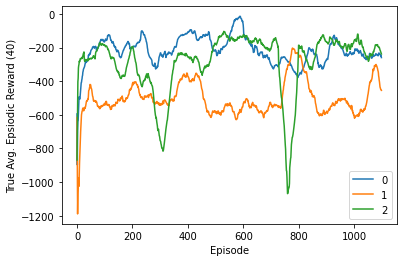

TypeError: 'module' object is not callable

In [11]:
run(total_trials=3, total_episodes=1100, std_dev_func=a, save_weights=True)

In [ ]:
#run(total_trials=2, total_episodes=1000, buffer_capacity=250000, std_dev_func=a, save_weights=True)

In [ ]:
test(render=True)